In [274]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import sympy as sy
from sympy.solvers import solve

In [275]:
# Discretization of triangle
# Generate the grid and mash in 2D plane
tolerance = 0.01

lambda1 = np.array([1./3., 1./3.])
lambda5 = np.array([0.5 - 0.5*tolerance, 0.5 - 0.5*tolerance])
lambda15 = [1.0 - 2*tolerance, tolerance]

lambda2 = lambda1 + 0.25 * (lambda5 - lambda1)
lambda3 = lambda1 + 0.50 * (lambda5 - lambda1)
lambda4 = lambda1 + 0.75 * (lambda5 - lambda1)
lambda6 = lambda1 + 0.25 * (lambda15 - lambda1)
lambda9 = lambda5 + 0.25 * (lambda15 - lambda5)
lambda10 = lambda1 + 0.50 * (lambda15 - lambda1)
lambda12 = lambda5 + 0.50 * (lambda15 - lambda5)
lambda13 = lambda1 + 0.75 * (lambda15 - lambda1)
lambda14 = lambda5 + 0.75 * (lambda15 - lambda5)

# Define the intersections of two lines
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

lambda7 = np.array(line_intersection((lambda2,lambda14),(lambda3,lambda10)))
lambda8 = np.array(line_intersection((lambda4,lambda13),(lambda3,lambda12)))
lambda11 = np.array(line_intersection((lambda2,lambda14),(lambda4,lambda13)))

tri_domain = (lambda5, lambda1, lambda15)

z_points = [0.10, 0.14, 0.18]
difference = z_points[2]-z_points[0]

# Create a dictionary for nodes
nodes = {'lambda1':lambda1,
        'lambda2':lambda2,
        'lambda3':lambda3,
        'lambda4':lambda4,
        'lambda5':lambda5,
        'lambda6':lambda6,
        'lambda7':lambda7,
        'lambda8':lambda8,
        'lambda9':lambda9,
        'lambda10':lambda10,
        'lambda11':lambda11,
        'lambda12':lambda12,
        'lambda13':lambda13,
        'lambda14':lambda14,
        'lambda15':lambda15}

key, coor = zip(*nodes.items())

In [276]:
# Create and add triangles into a list
triangles=[]

triangles.append((lambda2,lambda1,lambda6))#0
triangles.append((lambda2,lambda6,lambda7))#1#
triangles.append((lambda3,lambda2,lambda7))#2
triangles.append((lambda3,lambda7,lambda8))#3#
triangles.append((lambda4,lambda3,lambda8))#4
triangles.append((lambda4,lambda8,lambda9))#5#
triangles.append((lambda5,lambda4,lambda9))#6
triangles.append((lambda7,lambda6,lambda10))#7
triangles.append((lambda7,lambda10,lambda11))#8#
triangles.append((lambda8,lambda7,lambda11))#9
triangles.append((lambda8,lambda11,lambda12))#10#
triangles.append((lambda9,lambda8,lambda12))#11
triangles.append((lambda11,lambda10,lambda13))#12
triangles.append((lambda11,lambda13,lambda14))#13#
triangles.append((lambda12,lambda11,lambda14))#14
triangles.append((lambda14,lambda13,lambda15))#15

# Two directions of triangle,we generate two sets to save those two directional triangles seperately
TriDirection1 = [triangles[0], triangles[2], triangles[4], triangles[6], triangles[7], triangles[9], triangles[11], triangles[12], triangles[14], triangles[15]]
TriDirection2 = [triangles[1], triangles[3], triangles[5], triangles[8], triangles[10], triangles[13]]

In [277]:
# Define shape functions for tetrahedral FEM

def ShapeFunction_tetrahedral(V_A=[], V_B=[], V_C=[], V_D=[], P=[]):
    lam1_coor = P[0]
    lam2_coor = P[1]
    z_RanPt = P[2]
    
    global x1, x2, x3, x4
    x1 = V_A[0]
    x2 = V_B[0]
    x3 = V_C[0]
    x4 = V_D[0]
    global y1, y2, y3, y4
    y1 = V_A[1]
    y2 = V_B[1]
    y3 = V_C[1]
    y4 = V_D[1]
    global z1, z2, z3, z4
    z1 = V_A[2]
    z2 = V_B[2]
    z3 = V_C[2]
    z4 = V_D[2]
    
    x,y,z = sy.symbols("x,y,z", real=True)
    
    solution = solve([lam1_coor-(x1+(x2-x1)*x+(x3-x1)*y+(x4-x1)*z), lam2_coor-(y1+(y2-y1)*x+(y3-y1)*y+(y4-y1)*z), 
                      z_RanPt-(z1+(z2-z1)*x+(z3-z1)*y+(z4-z1)*z)], (x, y, z), dict = True)
    key, val = zip(*solution[0].items())
    
    global s1, s2, s3, s4
    s1 = 1-val[0]-val[1]-val[2]
    s2 = val[0]
    s3 = val[1]
    s4 = val[2]
    
    return [s1, s2, s3, s4]

In [278]:
# To check a point locate within a triangle or not (including on boundary)
def point_in_triangle(point, triangle):
    """Returns True if the point is inside the triangle
    and returns False if it falls outside.
    - The argument *point* is a tuple with two elements
    containing the X,Y coordinates respectively.
    - The argument *triangle* is a tuple with three elements each
    element consisting of a tuple of X,Y coordinates.

    It works like this:
    Walk clockwise or counterclockwise around the triangle
    and project the point onto the segment we are crossing
    by using the dot product.
    Finally, check that the vector created is on the same side
    for each of the triangle's segments.
    """
    # Unpack arguments
    x, y = point
    ax, ay = triangle[0]
    bx, by = triangle[1]
    cx, cy = triangle[2]
    # Segment A to B
    side_1 = (x - bx) * (ay - by) - (ax - bx) * (y - by)
    # Segment B to C
    side_2 = (x - cx) * (by - cy) - (bx - cx) * (y - cy)
    # Segment C to A
    side_3 = (x - ax) * (cy - ay) - (cx - ax) * (y - ay)
    # All the signs must be positive or all negative
    return (side_1 < 0.0) == (side_2 < 0.0) == (side_3 < 0.0)

def find_key(input_dict, value):
    return {k for k, v in input_dict.items() if np.array_equal(v,value)}

In [279]:
# From https://stackoverflow.com/questions/25179693/how-to-check-whether-the-point-is-in-the-tetrahedron-or-not
def sameside(V_A, V_B, V_C, V_D, P):
    normal = np.cross(V_B-V_A, V_C-V_A)
    return (np.dot(normal, V_D-V_A) * np.dot(normal, P-V_A) > 0)

def pointInside(V_A, V_B, V_C, V_D, P):   
    return sameside(V_A, V_B, V_C, V_D, P) and sameside(V_B, V_C, V_D, V_A, P) and sameside(V_C, V_D, V_A, V_B, P) and sameside(V_D, V_A, V_B, V_C, P)      

In [280]:
# Verify the orthogonality of matrix R

def check_orthogonal(M):
    # make sure the input is a matrix
    if len(np.shape(M)) != 2:
        print("error: input is not a matrix")
        return False
    # make sure the input is a square matrix
    dim = np.shape(M)[0]
    if dim != np.shape(M)[1]:
        print("error: input is not a square matrix")
        return False
    A = np.dot(M, M.T)
    if np.allclose(A, np.identity(dim)):
        #print("matrix is orthogonal")
        return True
    else:
        #print("matrix is not orthogonal")
        return False

In [281]:
# Generate matrix A and its eigenvalues as coordinate of the random point

matirces_A = []
matrices_R = []
transpose_R = []

for i in range(0,100):
    
    # Generate random matrix A
    A_random = np.random.rand(3,3)
    A_symmetric = 0.5 * (A_random + np.transpose(A_random))
    w,R = np.linalg.eig(A_symmetric)
    Rt  = np.transpose(R)
    w   = w.clip(min=0.01)
    w  /= np.linalg.norm(w, 1)
    wDiagonal = np.diag(w)

    A_positiveDefinite = np.real(np.dot(np.dot(R, wDiagonal), Rt))
    
    # Compute eigenvalues and eigenvectors of A
    evalue, evect = np.linalg.eig(A_positiveDefinite)
    evalue1 = np.sort(evalue)[::-1]
    EV_coor = [evalue1[0], evalue1[1]]
    
    # Check the random point located within triangle && all of entries in matrix A is positive  
    if check_orthogonal(R):
        if point_in_triangle(EV_coor, tri_domain):
            matirces_A.append(A_positiveDefinite)
            matrices_R.append(R)
            transpose_R.append(Rt)
        
# Use first matrix from list matirces_A for plotting and computation
evalue2, evect2 = np.linalg.eig(matirces_A[0])
evalue3 = np.sort(evalue2)[::-1]
random_point_new = [evalue3[0], evalue3[1]]
random_point_new_3d = [evalue3[0], evalue3[1], random.uniform(z_points[0], z_points[2])]

print('The fiber orientation tensor A is:')
print(matirces_A[0])
print('The eigenvalue of matrix A is: ',evalue2)
print('')

print('The matrix R is:')
print(matrices_R[0])
print('The orthogonality of matrix R: ',check_orthogonal(matrices_R[0]))
print('')

print('The transpose of matrix R is:')
print(transpose_R[0])
print('')

print('Generated random point is:')
print(random_point_new_3d)
print('')

The fiber orientation tensor A is:
[[0.24057423 0.14166501 0.05457727]
 [0.14166501 0.41712875 0.2511292 ]
 [0.05457727 0.2511292  0.34229702]]
The eigenvalue of matrix A is:  [0.68055235 0.21927111 0.10017655]

The matrix R is:
[[-0.31186809 -0.83958116  0.44479408]
 [-0.73809134 -0.08070805 -0.66985624]
 [-0.59829714  0.53720545  0.59451731]]
The orthogonality of matrix R:  True

The transpose of matrix R is:
[[-0.31186809 -0.73809134 -0.59829714]
 [-0.83958116 -0.08070805  0.53720545]
 [ 0.44479408 -0.66985624  0.59451731]]

Generated random point is:
[0.6805523468470653, 0.21927110684114648, 0.13972345122805435]



In [282]:
# Find the nearest triangle for random point

print('We found the random node in following triangle: ')
triangle_nodes = []

for coordinate in coor:
    for triangle in triangles:
        if point_in_triangle(random_point_new, triangle):
            for j in range(3):
                if np.array_equal(coordinate, triangle[j]):
                    print(find_key(nodes, triangle[j]))
                    print(triangle[j])
                    triangle_nodes.append(triangle[j])
                    
triangle_nodes = tuple(triangle_nodes)

result = [1]
for i in TriDirection2: 
    if np.array_equal(i, triangle_nodes):
        result.append(2)

We found the random node in following triangle: 
{'lambda7'}
[0.53541667 0.29291667]
{'lambda10'}
[0.65666667 0.17166667]
{'lambda11'}
[0.69708333 0.21208333]
[(array([0.37375, 0.37375]), array([0.33333333, 0.33333333]), array([0.495 , 0.2525])), (array([0.41416667, 0.41416667]), array([0.37375, 0.37375]), array([0.53541667, 0.29291667])), (array([0.45458333, 0.45458333]), array([0.41416667, 0.41416667]), array([0.57583333, 0.33333333])), (array([0.495, 0.495]), array([0.45458333, 0.45458333]), array([0.61625, 0.37375])), (array([0.53541667, 0.29291667]), array([0.495 , 0.2525]), array([0.65666667, 0.17166667])), (array([0.57583333, 0.33333333]), array([0.53541667, 0.29291667]), array([0.69708333, 0.21208333])), (array([0.61625, 0.37375]), array([0.57583333, 0.33333333]), array([0.7375, 0.2525])), (array([0.69708333, 0.21208333]), array([0.65666667, 0.17166667]), array([0.81833333, 0.09083333])), (array([0.7375, 0.2525]), array([0.69708333, 0.21208333]), array([0.85875, 0.13125])), (ar

In [283]:
# Define and change the number of layers

layers = int(2)
print('We have now '+str(layers)+' layer(s):')

layers_list = []

for i in range(0, layers):
    layers_list.append((i*(difference/layers)+z_points[0], (i+1)*(difference/layers)+z_points[0]))
    print('The layer {0} from'.format(i+1), layers_list[i])
    
for start, stop in layers_list:
    if start <= random_point_new_3d[2] <= stop:
        located_layer = (start, stop)
        for pair in layers_list:
            if located_layer == pair:
                global index
                index = layers_list.index(pair)
                print('We found the random point in layer '+str(index+1))

We have now 2 layer(s):
The layer 1 from (0.1, 0.14)
The layer 2 from (0.14, 0.18)
We found the random point in layer 1


In [284]:
# Find the nearest prism for random point

prism_nodes = []

# to add nodes in different layer, layer by layer
if len(result) == 1:
    for i in [1,0,2]:
        prism_node_1 = np.append(triangle_nodes[i], layers_list[index][0])
        prism_nodes.append(prism_node_1)
    for j in [1,0,2]:
        prism_node_2 = np.append(triangle_nodes[j], layers_list[index][1])
        prism_nodes.append(prism_node_2)
elif len(result) == 2:
    for i in range(0,3):
        prism_node_1 = np.append(triangle_nodes[i], layers_list[index][0])
        prism_nodes.append(prism_node_1)
    for j in range(0,3):
        prism_node_2 = np.append(triangle_nodes[j], layers_list[index][1])
        prism_nodes.append(prism_node_2)
    
print(prism_nodes)

[array([0.53541667, 0.29291667, 0.1       ]), array([0.65666667, 0.17166667, 0.1       ]), array([0.69708333, 0.21208333, 0.1       ]), array([0.53541667, 0.29291667, 0.14      ]), array([0.65666667, 0.17166667, 0.14      ]), array([0.69708333, 0.21208333, 0.14      ])]


In [285]:
# Construct three tetrahedrals within prism

tet1 = [[prism_nodes[4], prism_nodes[0], prism_nodes[1], prism_nodes[2]], 
        [prism_nodes[2], prism_nodes[5], prism_nodes[3], prism_nodes[4]],
        [prism_nodes[3], prism_nodes[0], prism_nodes[4], prism_nodes[2]]]

tet2 = [[prism_nodes[5], prism_nodes[1], prism_nodes[2], prism_nodes[0]],
        [prism_nodes[0], prism_nodes[3], prism_nodes[4], prism_nodes[5]],
        [prism_nodes[4], prism_nodes[1], prism_nodes[5], prism_nodes[0]]]

# Check the nearest tetrahedral for random point
tetrahedral_nodes = []

if len(result) == 1:
    for i in tet1:
        if pointInside(i[0], i[1], i[2], i[3], random_point_new_3d):
            print('The random point locates in triangle direction 1, and the four nodes of tetrahedral:')
            print(i)
            tetrahedral_nodes.append(i)
elif len(result) == 2:
    for j in tet2:
         if pointInside(j[0], j[1], j[2], j[3], random_point_new_3d):
            print('The random point locates in triangle direction 2, and the four nodes of tetrahedral:')
            print(j)
            tetrahedral_nodes.append(j)

The random point locates in triangle direction 2, and the four nodes of tetrahedral:
[array([0.53541667, 0.29291667, 0.1       ]), array([0.53541667, 0.29291667, 0.14      ]), array([0.65666667, 0.17166667, 0.14      ]), array([0.69708333, 0.21208333, 0.14      ])]


In [286]:
print('Values of s1, s2 ,s3 and s4: ')
print(ShapeFunction_tetrahedral(tetrahedral_nodes[0][0], tetrahedral_nodes[0][1], tetrahedral_nodes[0][2], tetrahedral_nodes[0][3], random_point_new_3d))

x_ran = x1*s1+x2*s2+x3*s3+x4*s4
y_ran = y1*s1+y2*s2+y3*s3+y4*s4
z_ran = z1*s1+z2*s2+z3*s3+z4*s4

print(random_point_new_3d)
print([x_ran, y_ran, z_ran])

Values of s1, s2 ,s3 and s4: 
(0.00691371929864260, 0.0908956002645780, 0.0177768203764283, 0.884413860060351)
[0.6805523468470653, 0.21927110684114648, 0.13972345122805435]
[0.680552346847066, 0.219271106841146, 0.139723451228054]


<ipython-input-287-51b48b88903c>:131: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3d.set_xticklabels(xlabels, fontsize=7)
<ipython-input-287-51b48b88903c>:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3d.set_yticklabels(ylabels, fontsize=7)
<ipython-input-287-51b48b88903c>:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3d.set_zticklabels(zlabels, fontsize=7.5)


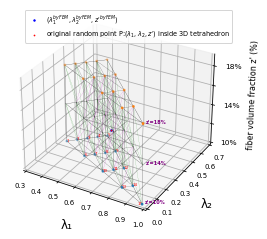

In [287]:
# Generate points 

x_points = []
y_points = []

for i in range(0,len(coor)):
    x_points.append(coor[i][0])
    y_points.append(coor[i][1])
    
x_points = np.array(x_points)
y_points = np.array(y_points)
z1 = np.full(shape=len(x_points), fill_value=z_points[0])
z2 = np.full(shape=len(x_points), fill_value=z_points[2])

fig_3d = plt.figure()
ax_3d = plt.axes(projection='3d')
ax_3d.scatter3D(x_points, y_points, z1, s=3)
ax_3d.scatter3D(x_points, y_points, z2, s=3)
#ax_3d.view_init(60, 35)

# Plot generated random point in 3D
ax_3d.scatter3D(x_ran, y_ran, z_ran, label='''($λ_1^{byFEM},λ_2^{byFEM},z'^{byFEM}$)''', color='b', s=2)
ax_3d.scatter3D(random_point_new_3d[0], random_point_new_3d[1], random_point_new_3d[2], label='''original random point P:($λ_1,λ_2,z'$) inside 3D tetrahedron''', color='r', s=0.5)

# Annotate 2D grid
ax_3d.text(lambda1[0],lambda1[1], z_points[0], "1", color='red',size=4)
ax_3d.text(lambda2[0],lambda2[1], z_points[0], "2", color='red',size=4)
ax_3d.text(lambda3[0],lambda3[1], z_points[0], "3", color='red',size=4)
ax_3d.text(lambda4[0],lambda4[1], z_points[0], "4", color='red',size=4)
ax_3d.text(lambda5[0],lambda5[1], z_points[0], "5", color='red',size=4)
ax_3d.text(lambda6[0],lambda6[1], z_points[0], "6", color='red',size=4)
ax_3d.text(lambda7[0],lambda7[1], z_points[0], "7", color='red',size=4)
ax_3d.text(lambda8[0],lambda8[1], z_points[0], "8", color='red',size=4)
ax_3d.text(lambda9[0],lambda9[1], z_points[0], "9", color='red',size=4)
ax_3d.text(lambda10[0],lambda10[1], z_points[0], "10", color='red',size=4)
ax_3d.text(lambda11[0],lambda11[1], z_points[0], "11", color='red',size=4)
ax_3d.text(lambda12[0],lambda12[1], z_points[0], "12", color='red',size=4)
ax_3d.text(lambda13[0],lambda13[1], z_points[0], "13", color='red',size=4)
ax_3d.text(lambda14[0],lambda14[1], z_points[0], "14", color='red',size=4)
ax_3d.text(lambda15[0],lambda15[1], z_points[0], "15", color='red',size=4, horizontalalignment='right')

# Annotate three layers
ax_3d.text(lambda15[0]+0.01,lambda15[1]+0.01, z_points[0], '''z'=10%''', color='purple',size=5, weight='bold')
ax_3d.text(lambda15[0]+0.01,lambda15[1]+0.01, z_points[1], '''z'=14%''', color='purple',size=5, weight='bold')
ax_3d.text(lambda15[0]+0.01,lambda15[1]+0.01, z_points[2], '''z'=18%''', color='purple',size=5, weight='bold')

# Generate lines
ax_3d.plot([lambda1[0], lambda15[0]], [lambda1[1], lambda15[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')
ax_3d.plot([lambda2[0], lambda14[0]], [lambda2[1], lambda14[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda3[0], lambda12[0]], [lambda3[1], lambda12[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda4[0], lambda9[0]], [lambda4[1], lambda9[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda1[0], lambda5[0]], [lambda1[1], lambda5[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')
ax_3d.plot([lambda6[0], lambda9[0]], [lambda6[1], lambda9[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda10[0], lambda12[0]], [lambda10[1], lambda12[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda13[0], lambda14[0]], [lambda13[1], lambda14[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda2[0], lambda6[0]], [lambda2[1], lambda6[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda3[0], lambda10[0]], [lambda3[1], lambda10[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda4[0], lambda13[0]], [lambda4[1], lambda13[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda5[0], lambda15[0]], [lambda5[1], lambda15[1]], z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')

ax_3d.plot([lambda1[0], lambda15[0]], [lambda1[1], lambda15[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'solid')
ax_3d.plot([lambda2[0], lambda14[0]], [lambda2[1], lambda14[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda3[0], lambda12[0]], [lambda3[1], lambda12[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda4[0], lambda9[0]], [lambda4[1], lambda9[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda1[0], lambda5[0]], [lambda1[1], lambda5[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'solid')
ax_3d.plot([lambda6[0], lambda9[0]], [lambda6[1], lambda9[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda10[0], lambda12[0]], [lambda10[1], lambda12[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda13[0], lambda14[0]], [lambda13[1], lambda14[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda2[0], lambda6[0]], [lambda2[1], lambda6[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda3[0], lambda10[0]], [lambda3[1], lambda10[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda4[0], lambda13[0]], [lambda4[1], lambda13[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'dashed')
ax_3d.plot([lambda5[0], lambda15[0]], [lambda5[1], lambda15[1]], z_points[2], color = 'k', linewidth = 0.2, linestyle = 'solid')

# Plot different layers
for i in range(1,layers):
    ax_3d.plot([lambda1[0], lambda15[0]], [lambda1[1], lambda15[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')
    ax_3d.plot([lambda2[0], lambda14[0]], [lambda2[1], lambda14[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda3[0], lambda12[0]], [lambda3[1], lambda12[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda4[0], lambda9[0]], [lambda4[1], lambda9[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda1[0], lambda5[0]], [lambda1[1], lambda5[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')
    ax_3d.plot([lambda6[0], lambda9[0]], [lambda6[1], lambda9[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda10[0], lambda12[0]], [lambda10[1], lambda12[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda13[0], lambda14[0]], [lambda13[1], lambda14[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda2[0], lambda6[0]], [lambda2[1], lambda6[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda3[0], lambda10[0]], [lambda3[1], lambda10[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda4[0], lambda13[0]], [lambda4[1], lambda13[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'dashed')
    ax_3d.plot([lambda5[0], lambda15[0]], [lambda5[1], lambda15[1]], i*(difference/layers)+z_points[0], color = 'k', linewidth = 0.2, linestyle = 'solid')

# Divide prisms into three tetrahedrals
for i in TriDirection1:
    ax_3d.plot([i[0][0], i[2][0]], [i[0][1], i[2][1]], [z_points[1], z_points[0]], color='g', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([i[0][0], i[2][0]], [i[0][1], i[2][1]], [z_points[2], z_points[1]], color='g', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([i[1][0], i[2][0]], [i[1][1], i[2][1]], [z_points[1], z_points[0]], color='g', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([i[1][0], i[2][0]], [i[1][1], i[2][1]], [z_points[2], z_points[1]], color='g', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [z_points[0], z_points[1]], color='g', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [z_points[1], z_points[2]], color='g', linewidth = '0.1', linestyle = 'solid')
for j in TriDirection2:  
    ax_3d.plot([j[0][0], j[1][0]], [j[0][1], j[1][1]], [z_points[0], z_points[1]], color='m', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([j[0][0], j[1][0]], [j[0][1], j[1][1]], [z_points[1], z_points[2]], color='m', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([j[0][0], j[2][0]], [j[0][1], j[2][1]], [z_points[0], z_points[1]], color='m', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([j[0][0], j[2][0]], [j[0][1], j[2][1]], [z_points[1], z_points[2]], color='m', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([j[1][0], j[2][0]], [j[1][1], j[2][1]], [z_points[0], z_points[1]], color='m', linewidth = '0.1', linestyle = 'solid')
    ax_3d.plot([j[1][0], j[2][0]], [j[1][1], j[2][1]], [z_points[1], z_points[2]], color='m', linewidth = '0.1', linestyle = 'solid')
    
    
# Connection of upper and bottom planes
from_pts = []
for ea in np.stack((x_points, y_points, z1), axis=-1):
    from_pts.append(ea)

dest_pts = []
for ea2 in np.stack((x_points, y_points, z2), axis=-1):
    dest_pts.append(ea2)
    
for from_to in zip(from_pts, dest_pts):
    ax_3d.plot([from_to[0][0],from_to[1][0]], 
               [from_to[0][1],from_to[1][1]], 
               [from_to[0][2],from_to[1][2]], "k", linewidth=0.2)
    
subscript = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
ax_3d.set_xlabel('λ1'.translate(subscript), fontsize=12)
ax_3d.set_ylabel('λ2'.translate(subscript), fontsize=12)
ax_3d.set_zlabel('''fiber volume fraction z' (%)''', fontsize=8)
ax_3d.set_xlim3d(0.3,1)
ax_3d.set_ylim3d(0,0.7)
ax_3d.set_zlim3d(z_points[0],z_points[2]+0.01)
ax_3d.legend(loc=0, bbox_to_anchor=(1.05, 1),fontsize=6.5)

# set ticks
xlabels = [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
ax_3d.set_xticklabels(xlabels, fontsize=7)
ax_3d.tick_params(axis='x', which='major', pad=0.5)

ylabels = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
ax_3d.set_yticklabels(ylabels, fontsize=7)
ax_3d.tick_params(axis='y', which='major', pad=1)

zlabels = [item.get_text() for item in ax_3d.get_zticklabels()]
zlabels[0] = '10%'
zlabels[2] = '14%'
zlabels[4] = '18%'
ax_3d.set_zticklabels(zlabels, fontsize=7.5)

#ax_3d.set_title('3D shape function and unit triangulation prism')

fig_3d.savefig('StandardTetrahedral_3D (10%-18%).png', dpi=300, bbox_inches='tight')